# Example 3: Monte Carlo Markov Chain based approach for the component parameters update.

This example uses MCMC on the analytical reservoir model to produce posterior distributions for the reservoir permeability (logResPerm), reservoir porosity (reservoirPorosity) and reservoir thickness (reservoirThickness)- parameters constrained by measured values of pressure and |CO2| saturation at monitoring well. The posterior parameter values are then run through the multisegmented wellbore model in order to propagate the uncertainty to the brine and CO$_2$ leakage at leaking well.
Permeability of the leaking well is defined as a stochastic parameter.

For plots shown in the example we set the backend of matplotlib to the 'inline' backend (specific for Jupyter notebooks) so that result of any plotting command is displayed inline directly below the code cell that produces it.

In [1]:
%matplotlib inline

#### 1) Import the standard and third party needed libraries.

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from openiam.matk import logposteriorwithvariance

#### 2) Import classes of NRAP-Open-IAM utilized in the example.

In [3]:
from openiam.components.iam_base_classes import SystemModel
from openiam.components.analytical_reservoir_component import AnalyticalReservoir
from openiam.components.multisegmented_wellbore_component import MultisegmentedWellbore

#### 3) Setup parameters of the simulation and Markov Chain Monte Carlo method.

In [4]:
# Define data measurement frequency parameters
param_dist = 1  # 1 for Gaussian distribution; 2 for Uniform distribution
n_type_data = 2  # Number of measurement types
num_years = 5  # Total time for acquiring data
data_freq = 12  # The number of measurements per year

In [5]:
# Define locations of the monitoring and target well
# x- and y-coordinates of the monitoring well
locX_monitor = 50.0
locY_monitor = 50.0
# x- and y-coordinates of the target well for which
# the uncertainty in the leakage rates is to be quantified
locX_leakwell = 200.0
locY_leakwell = 200.0 

In [6]:
# Define pressure and saturation measurement or data assimilation error tolerance
pres_err = 137895  # 137895 Pa = 20 psi
sat_err = 0.02

nwalkers = 20  # Number of MCMC chains
nsamples_per_walker = 200  # Number of samples (exclusive burnin samples) per chain (walker)
burnin = 50  # Number of samples to throw away at the beginning of chains

#### 4) Setup the first system model to produce synthetic data.

In [7]:
# Define keyword arguments of the system model
num_time_series = num_years*data_freq
time_array = 365.25/data_freq*np.arange(0.0, num_time_series+1)
print('System model time points (in days):\n', time_array)
# For system model setup time is provided in days
sm1_model_kwargs = {'time_array': time_array}

System model time points (in days):
 [   0.       30.4375   60.875    91.3125  121.75    152.1875  182.625   213.0625  243.5     273.9375  304.375   334.8125  365.25    395.6875  426.125   456.5625  487.      517.4375  547.875   578.3125  608.75    639.1875  669.625   700.0625  730.5     760.9375  791.375   821.8125  852.25    882.6875  913.125   943.5625  974.     1004.4375 1034.875  1065.3125 1095.75   1126.1875 1156.625  1187.0625 1217.5    1247.9375 1278.375  1308.8125 1339.25   1369.6875 1400.125  1430.5625 1461.     1491.4375 1521.875  1552.3125 1582.75   1613.1875 1643.625  1674.0625 1704.5    1734.9375 1765.375  1795.8125 1826.25  ]


In [8]:
# Create system model
sm1 = SystemModel(model_kwargs=sm1_model_kwargs)

#### 5) Add reservoir component to the first system model. 
Observations of the reservoir component, pressure and CO$_2$ saturation at the monitoring well, augmented with the noise will serve as a source of synthetic "measured" data (for illustration purposes).

In [9]:
# Add reservoir component model
ares = sm1.add_component_model_object(AnalyticalReservoir(
    name='ares', parent=sm1, locX=locX_monitor, locY=locY_monitor))

In [10]:
# Add parameters of reservoir component model
ares.add_par('logResPerm', min=-14., max=-12., value=-13.)
ares.add_par('reservoirPorosity', min=0.1, max=0.3, value=0.2)
ares.add_par('reservoirThickness', min=20., max=40., value=30)
ares.add_par('reservoirRadius', value=3000, vary=False)

In [11]:
# Add observations of reservoir component model
# By default observations at all time points of time_array are added
ares.add_obs('pressure')
ares.add_obs('CO2saturation')

#### 6) Create synthetic observations for MCMC method.
Synthetic observations are created by running the system model forward with specified parameter values defined above in add_par calls.

In [12]:
# Run system model using current values of its parameters
sm1.forward()

OrderedDict([('ares.pressure_0', 9830275.0),
             ('ares.pressure_1', 10311396.836950975),
             ('ares.pressure_2', 10269958.229134517),
             ('ares.pressure_3', 10239414.504443398),
             ('ares.pressure_4', 10215070.542359628),
             ('ares.pressure_5', 10194668.852417149),
             ('ares.pressure_6', 10177002.996676104),
             ('ares.pressure_7', 10161354.288097585),
             ('ares.pressure_8', 10147259.25645299),
             ('ares.pressure_9', 10134400.903040886),
             ('ares.pressure_10', 10122552.410406444),
             ('ares.pressure_11', 10111545.608191125),
             ('ares.pressure_12', 10101252.169257114),
             ('ares.pressure_13', 10091571.817531165),
             ('ares.pressure_14', 10082424.620049842),
             ('ares.pressure_15', 10073745.770861642),
             ('ares.pressure_16', 10065481.955754604),
             ('ares.pressure_17', 10057588.753795665),
             ('ares.pressure_1

In [13]:
# Collect observations from the system model
true_pres = sm1.collect_observations_as_time_series(ares, 'pressure')
true_sat = sm1.collect_observations_as_time_series(ares, 'CO2saturation')

In [14]:
# Add noise (measurement error) to data
ndata = n_type_data*len(time_array)
norm_nums = np.random.normal(0, 1, ndata)
pres_noise = pres_err*norm_nums[0:len(time_array)]
sat_noise = sat_err*norm_nums[len(time_array):ndata]
pres_list = true_pres + pres_noise
sat_list = true_sat + sat_noise

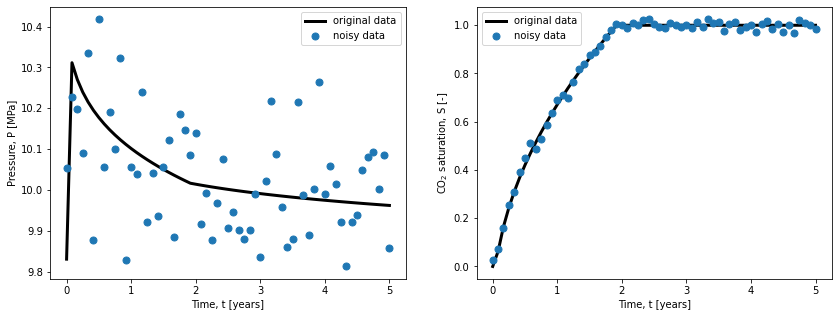

In [15]:
# Plot "true" and noisy data
# Define plot parameters
line_width = 3
orig_color = 'black'
noisy_color = '#1f77b4'
marker_size = 7

# Create figure
f, ax = plt.subplots(1, 2, figsize=(14, 5))

# Pressure subplot
ax[0].plot(time_array/365.25, true_pres/1.0e+6, '-', color=orig_color, label="original data", linewidth=line_width)
ax[0].plot(time_array/365.25, pres_list/1.0e+6, 'o', color=noisy_color, label="noisy data", markersize=marker_size)
ax[0].legend()
ax[0].set_xlabel('Time, t [years]')
ax[0].set_ylabel('Pressure, P [MPa]')

# CO2 saturation subplot
ax[1].plot(time_array/365.25, true_sat, '-k', color=orig_color, label="original data", linewidth=line_width)
ax[1].plot(time_array/365.25, sat_list, 'o', color=noisy_color, label="noisy data", markersize=marker_size)
ax[1].legend()
ax[1].set_xlabel('Time, t [years]')
ax[1].set_ylabel(r'CO$_2$ saturation, S [-]')
plt.show()

In [16]:
# Update reservoir component observations with synthetic data
ares.add_obs('pressure', index=list(range(num_time_series+1)), value=pres_list)
ares.add_obs('CO2saturation', index=list(range(num_time_series+1)), value=sat_list)

#### 7) Run MCMC on the updated reservoir component.
MCMC is run to to produce parameter posterior distributions based on consistency with reservoir model observations, pressure and CO$_2$ saturation at the monitoring well.

In [17]:
# Perform Markov Chain Monte Carlo sampling
lnprob = logposteriorwithvariance(sm1, var=[pres_err]*len(time_array) + [sat_err]*len(time_array))
ss = sm1.emcee(nwalkers=nwalkers, lnprob=lnprob, nsamples=nsamples_per_walker, burnin=burnin)

#### 8) Check the convergence of MCMC chain.
The following steps are involved:
 - calculation of statistical moments (mean and variance) for each sampled parameter;
 - plotting chains of the moments for each sampled parameter.
    

In [18]:
# Calculate the mean and variance of the MCMC samples
nMCMCSamples = nsamples_per_walker*nwalkers
step_size = nwalkers*2
step_num = int(nMCMCSamples/step_size)
mean_chain = np.zeros((3, step_num))
var_chain = np.zeros((3, step_num))

xx = []
for ind1 in range(0, step_num):
    for ind2 in range(3):
        mean_chain[ind2][ind1] = np.mean(ss.chain[:, 0:step_size*(ind1+1), ind2])
        var_chain[ind2][ind1] = np.var(ss.chain[:, 0:step_size*(ind1+1), ind2])
    
    val = (ind1+1)*step_size
    xx.append(val)

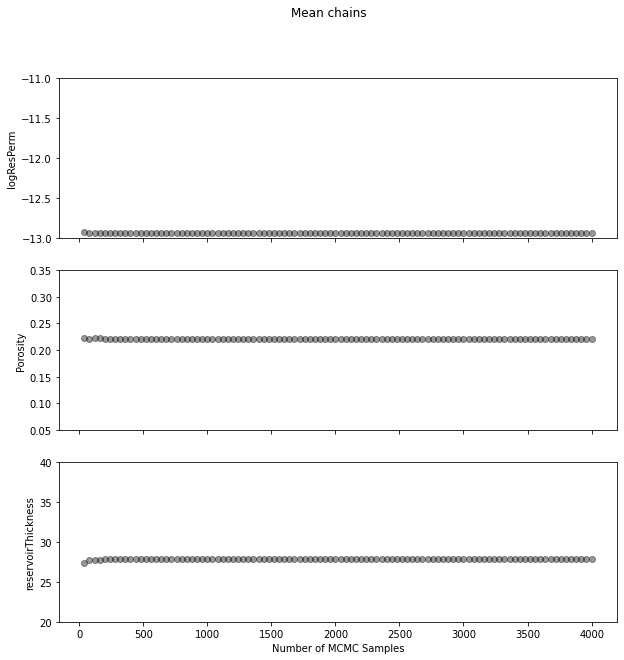

In [19]:
# Illustrate the convergence of MCMC chain
# Setup plot parameters
line_color = 'black'
horiz_line_color = 'gray'
alpha_const = 0.4

# Create first figure
f1, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax[0].plot(xx, mean_chain[0], 'o', color=line_color, alpha=alpha_const)
ax[0].set_ylabel('logResPerm')
ax[0].set_ylim(-13, -11)

ax[1].plot(xx, mean_chain[1], 'o', color=line_color, alpha=alpha_const)
ax[1].set_ylabel('Porosity')
ax[1].set_ylim(0.05, 0.35)

ax[2].plot(xx, mean_chain[2], 'o', color=line_color, alpha=alpha_const)
ax[2].set_xlabel('Number of MCMC Samples')
ax[2].set_ylabel('reservoirThickness')
ax[2].set_ylim(20., 40.)
plt.suptitle('Mean chains')
plt.show()

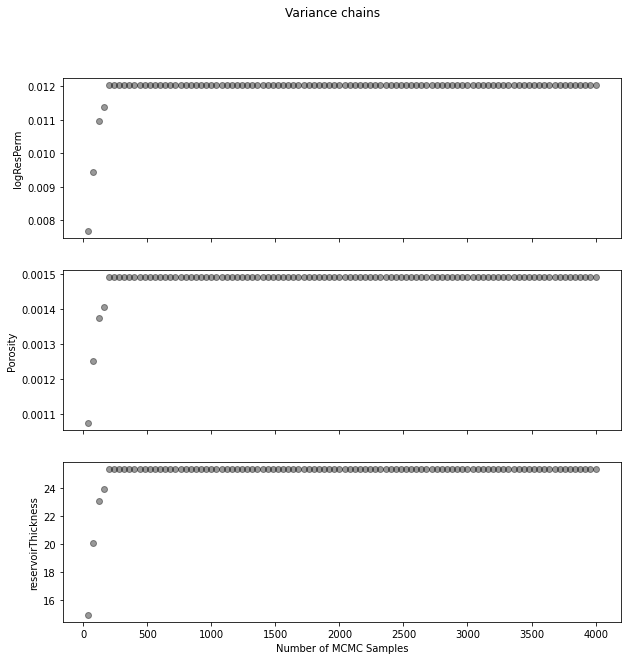

In [20]:
# Create second figure
f2, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax[0].plot(xx, var_chain[0], 'o', color=line_color, alpha=alpha_const)
ax[0].set_ylabel('logResPerm')

ax[1].plot(xx, var_chain[1], 'o', color=line_color, alpha=alpha_const)
ax[1].set_ylabel('Porosity')

ax[2].plot(xx, var_chain[2], 'o', color=line_color, alpha=alpha_const)
ax[2].set_xlabel('Number of MCMC Samples')
ax[2].set_ylabel('reservoirThickness')
plt.suptitle('Variance chains')
plt.show()

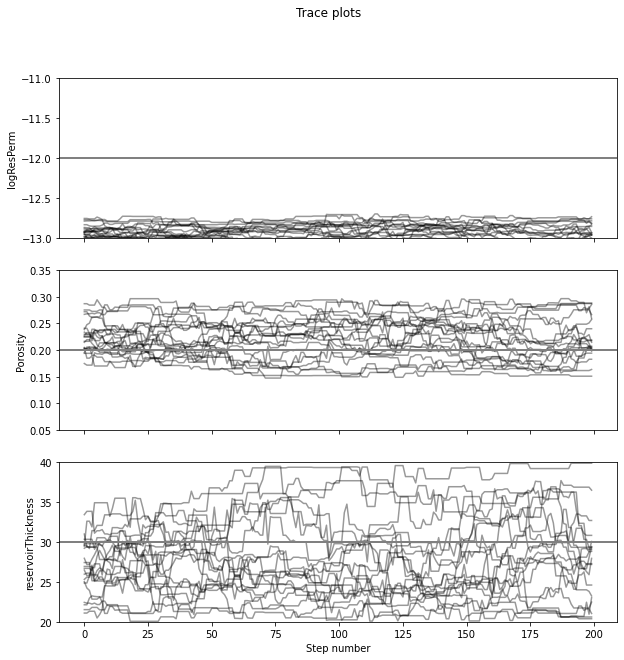

In [21]:
# Create trace plots.
# Permeability subplot
f3, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax[0].plot(ss.chain[:, :, 0].T, color=line_color, alpha=alpha_const)
ax[0].axhline(-12, color=horiz_line_color, lw=2)
ax[0].set_ylabel('logResPerm')
ax[0].set_ylim(-13, -11)

# Porosity subplot
ax[1].plot(ss.chain[:, :, 1].T, color=line_color, alpha=alpha_const)
ax[1].axhline(0.2, color=horiz_line_color, lw=2)
ax[1].set_ylabel('Porosity')
ax[1].set_ylim(0.05, 0.35)

# Thickness subplot
ax[2].plot(ss.chain[:, :, 2].T, color=line_color, alpha=alpha_const)
ax[2].axhline(30, color=horiz_line_color, lw=2)
ax[2].set_xlabel('Step number')
ax[2].set_ylabel('reservoirThickness')
ax[2].set_ylim(20., 40.)
plt.suptitle('Trace plots')
plt.show()

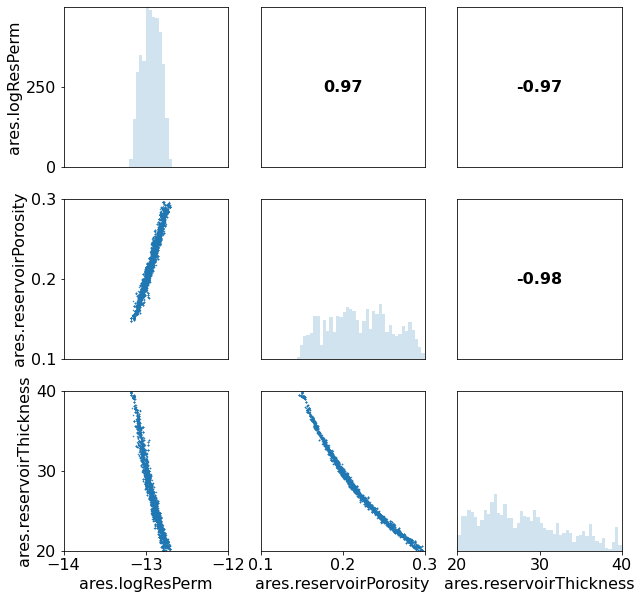

In [22]:
# Create panels plot to explore the histograms and correlations of parameter distributions
sc = sm1.create_sampleset(ss.chain[:, :, :].reshape((-1, len(sm1.pars))))
sc.panels(bins=50, figsize=(10, 10), fontsize=16, ms=1)

#### 9) Setup the second system model and run it to propagate uncertainty in the posterior parameter distribution.

In [23]:
# Define simulation parameters for the second system model
num_years = 10
time_array1 = 365.25*np.arange(0.0, num_years+1, step=0.25)
sm2_model_kwargs = {'time_array': time_array1}

In [24]:
# Create system model
sm2 = SystemModel(model_kwargs=sm2_model_kwargs)

#### 10) Add reservoir component to the second system model. 

In [25]:
# Add reservoir component to system model
# Note that the location is updated to be at the leaking well
ares = sm2.add_component_model_object(AnalyticalReservoir(
    name='ares', parent=sm2, locX=locX_leakwell, locY=locY_leakwell))

In [26]:
# Add parameters of reservoir component model
if param_dist == 1:  # Gaussian distribution for wellbore permeability
    ares.add_par('logResPerm', dist='norm', mean=-13, std=0.33)
    ares.add_par('reservoirPorosity', dist='norm', mean=0.2, std=0.033)
    ares.add_par('reservoirThickness', dist='norm', mean=30, std=3.3)
    ares.add_par('reservoirRadius', value=3000, vary=False)
elif param_dist == 2:  # Uniform distribution for wellbore permeability
    ares.add_par('logResPerm', min=-14., max=-12.)
    ares.add_par('reservoirPorosity', min=0.1, max=0.3)
    ares.add_par('reservoirThickness', min=20., max=40.)
    ares.add_par('reservoirRadius', value=3000, vary=False)
else:
    print('There is no such option for param_dist, please reset!')

In [27]:
# Add observations of reservoir component model to be used by the wellbore component
ares.add_obs_to_be_linked('pressure')
ares.add_obs_to_be_linked('CO2saturation')

#### 11) Add wellbore component to the second system model. 

In [28]:
# Add multisegmented wellbore component so that reservoir uncertainty
# can be propagated through a "default" wellbore to estimate 
# the uncertainty in CO2 and brine leakage.
ms = sm2.add_component_model_object(MultisegmentedWellbore(name='ms', parent=sm2))

In [29]:
# Add stochastic parameter of the wellbore component
if param_dist == 1:  # Guassian distribution for wellbore perm
    ms.add_par('logWellPerm', dist='norm', mean=-13.0, std=0.33)
elif param_dist==2:  # Uniform distribution for wellbore perm
    ms.add_par('logWellPerm', min=-14.0, max=-12.0)
else:
    print('There is no such option for param_dist, please reset!')

# Add parameters of wellbore component linked to the parameters
# of the same name from reservoir model. In this example most of wellbore
# component parameters assume default parameter values, thus, linked to the
# corresponding parameters of the reservoir model
par_names1 = ['numberOfShaleLayers', 'datumPressure']+3*['shaleThickness']+2*['aquiferThickness']
for par_nm in par_names1:
    ms.add_par_linked_to_par(par_nm, ares.default_pars[par_nm])
ms.add_par_linked_to_par('reservoirThickness', ares.pars['reservoirThickness'])

In [30]:
# Add keyword arguments linked to the output provided by reservoir model
ms.add_kwarg_linked_to_obs('pressure', ares.linkobs['pressure'])
ms.add_kwarg_linked_to_obs('CO2saturation', ares.linkobs['CO2saturation'])

In [31]:
# Add observations of multisegmented wellbore component
ms.add_obs('brine_aquifer1')
ms.add_obs('CO2_aquifer1')

#### 12) Create sample set including parameters of the reservoir and wellbore components.

In [32]:
mcmc_pars = ss.chain[:, :, :].reshape((-1, len(sm1.pars)))
if param_dist == 1:  # Guassian distribution for wellbore permeability
    wbperms = np.random.normal(-13, 0.15, len(mcmc_pars))
elif param_dist==2:  # Uniform distribution for wellbore permeability
    wbperm_min = -14
    wbperm_max=-12
    wbperms = wbperm_min+(wbperm_max-wbperm_min)*np.random.random(len(mcmc_pars))
else:
    print('There is no such option for param_dist, please reset!')
sc_pars = np.column_stack([mcmc_pars, wbperms])

#### 13) Obtain prior and posterior distribution of wellbore component observations.

In [33]:
# Run prior distribution through coupled model to determine
# prior uncertainty in leakage. The number of samples equals to 
# the number of MCMC samples minus the burnin for each chain
sprior = sm2.lhs(siz=nwalkers*nsamples_per_walker)
prior_res = sprior.run(cpus=2, verbose=False)

# Run posterior parameter distributions with multisegmented wellbore model
# added to the system model
sc = sm2.create_sampleset(sc_pars)
posterior_res = sc.run(cpus=4, verbose=False)

#### 14) Plot histograms illustrating prior and posterior distributions of wellbore component observations.

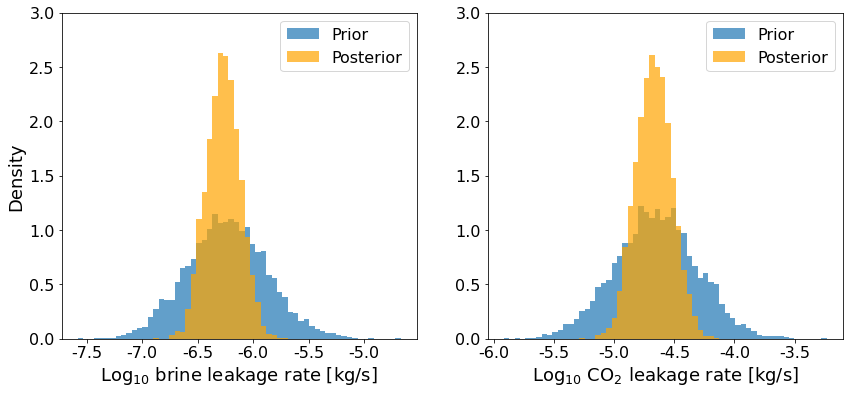

In [34]:
# Specify the index of time point of interest; 20 corresponds to 5 years
obs_ind = '_20' 

# Define observation names of interest
obs_names = [nm+obs_ind for nm in ['ms.brine_aquifer1', 'ms.CO2_aquifer1']]

# Setup labels for x-axis of the histograms
xlabels = [r"Log$_{10}$ brine leakage rate [kg/s]", r"Log$_{10}$ CO$_2$ leakage rate [kg/s]"]

# Obtain data
data = {}
for ind in range(2):
    data[2*ind+1] = sprior.recarray[obs_names[ind]]
    data[2*ind+2] = sc.recarray[obs_names[ind]]

# Define histogram parameters
num_bins = 60
alpha_const = 0.7
hist_labels = ['Prior', 'Posterior']
hist_colors = ['#1f77b4', 'orange']
font_size = 16
label_font_size = 18

# Create figure
f4, ax = plt.subplots(1, 2, figsize=(14, 6))
for ind1 in range(2):
    range_min = min(np.min(np.log10(data[2*ind1+1])), np.min(np.log10(data[2*ind1+2])))
    range_max = max(np.max(np.log10(data[2*ind1+1])), np.max(np.log10(data[2*ind1+2])))
    for ind2 in range(2):
        ax[ind1].hist(np.log10(data[2*ind1+ind2+1]), bins=num_bins, label=hist_labels[ind2],
                      range=(range_min, range_max), alpha=alpha_const, density=True, color=hist_colors[ind2])

# Set axes parameters
ax[0].set_ylabel("Density", fontsize=label_font_size)
for ind in range(2):
    ax[ind].set_ylim(0.0, 3.0)
    ax[ind].legend(fontsize=font_size)
    ax[ind].set_xlabel(xlabels[ind], fontsize=label_font_size)
    ax[ind].set_xticklabels(ax[ind].get_xticks(), fontsize=font_size)
    ax[ind].set_yticklabels(ax[ind].get_yticks(), fontsize=font_size)

#### 15) Plot cumulative distribution functions illustrating prior and posterior distributions of wellbore component observations.

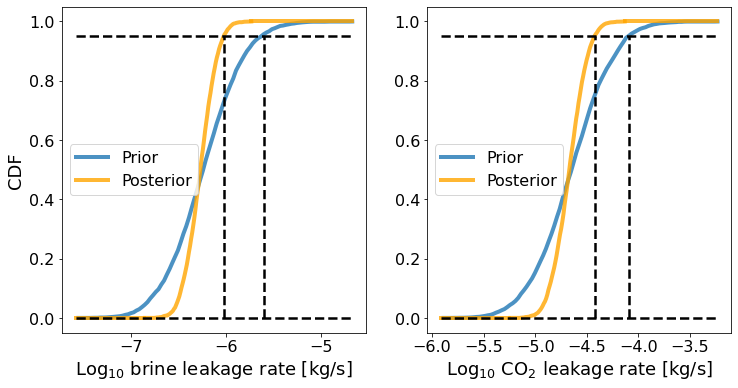

In [35]:
# Create figure
f5, ax = plt.subplots(1, 2, figsize=(12, 6))

# Define parameters of x-ticks and y-ticks size for all subplots
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Define CDFs parameters
num_bins = 100
prob = 0.95

# Define plots parameters
prior_line_color = '#1f77b4'
posterior_line_color = 'orange'
dash_line_color = 'black'
line_width = 4
dash_line_width = 2.5
alpha_const = 0.8
legend_font_size = 16
label_font_size = 18

# Create histogram for prior distribution of the brine leakage
hist, bin_edges = np.histogram(np.log10(data[1]), bins=num_bins)
# Calculate corresponding CDF
cdf = np.cumsum(hist)
cdf1 = np.zeros(num_bins)
for ind in range(0, num_bins):
    cdf1[ind] = float(cdf[ind])/nMCMCSamples

# Create histogram for posterior distribution of the brine leakage
hist_post, bin_edges_post = np.histogram(np.log10(data[2]), bins=num_bins)
# Calculate corresponding CDF
cdf_post = np.cumsum(hist_post)
cdf1_post = np.zeros(num_bins)
for ind in range(0, num_bins):
    cdf1_post[ind] = float(cdf_post[ind])/nMCMCSamples

# Plot CDFs
ax[0].plot(bin_edges[1:], cdf1, label="Prior", 
           alpha=alpha_const, linewidth=line_width, color=prior_line_color)
ax[0].plot(bin_edges_post[1:], cdf1_post, label="Posterior", 
           alpha=alpha_const, linewidth=line_width, color=posterior_line_color)
ax[0].plot([bin_edges_post[-1], bin_edges[-1]], [cdf1_post[-1], 1], 
           alpha=alpha_const, linewidth=line_width, color=posterior_line_color)
ax[0].plot([bin_edges[0], bin_edges_post[0]], [0.0, 0.0], 
           alpha=alpha_const, linewidth=line_width, color=posterior_line_color)
ax[0].plot([bin_edges[0], bin_edges[-1]], [prob, prob], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[0].plot([bin_edges[1:][cdf1>=prob][0], bin_edges[1:][cdf1>=prob][0]], [0.0, prob], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[0].plot([bin_edges_post[1:][cdf1_post>=prob][0], bin_edges_post[1:][cdf1_post>=prob][0]], [0.0, prob], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[0].plot([bin_edges[0], bin_edges[-1]], [0.0, 0.0], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[0].set_xlabel(xlabels[0], fontsize=label_font_size)
ax[0].set_ylabel('CDF', fontsize=label_font_size)
ax[0].legend(loc='center left', fontsize=legend_font_size)

# Create histogram for prior distribution of the CO2 leakage
hist, bin_edges = np.histogram(np.log10(data[3]), bins=num_bins)
# Calculate corresponding CDF
cdf = np.cumsum(hist)
cdf1 = np.zeros(num_bins)
for ind in range(0, num_bins):
    cdf1[ind] = float(cdf[ind])/nMCMCSamples

# Create histogram for posterior distribution of the brine leakage
hist_post, bin_edges_post = np.histogram(np.log10(data[4]), bins=num_bins)
# Calculate corresponding CDF
cdf_post = np.cumsum(hist_post)
cdf1_post = np.zeros(num_bins)
for ind in range(0, num_bins):
    cdf1_post[ind] = float(cdf_post[ind])/nMCMCSamples
    
# Plot CDFs
ax[1].plot(bin_edges[1:], cdf1, label="Prior", 
           alpha=alpha_const, linewidth=line_width, color=prior_line_color)
ax[1].plot(bin_edges_post[1:], cdf1_post, label="Posterior", 
           alpha=alpha_const, linewidth=line_width, color=posterior_line_color)
ax[1].plot([bin_edges_post[-1], bin_edges[-1]], [cdf1_post[-1], 1], 
           alpha=alpha_const, linewidth=line_width, color=posterior_line_color)
ax[1].plot([bin_edges[0], bin_edges_post[0]], [0.0, 0.0], 
           alpha=alpha_const, linewidth=line_width, color=posterior_line_color)
ax[1].plot([bin_edges[0], bin_edges[-1]], [prob, prob], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[1].plot([bin_edges[1:][cdf1>=prob][0], bin_edges[1:][cdf1>=prob][0]], [0.0, prob], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[1].plot([bin_edges_post[1:][cdf1_post>=prob][0], bin_edges_post[1:][cdf1_post>=prob][0]], [0.0, prob], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[1].plot([bin_edges[0], bin_edges[-1]], [0.0, 0.0], 
           '--', linewidth=dash_line_width, color=dash_line_color)
ax[1].set_xlabel(xlabels[1], fontsize=label_font_size)
ax[1].legend(loc='center left', fontsize=legend_font_size)
plt.show()